# Introduction
***
Notebook **#2-ensemble_modelling_daun_singkong_eksperimen_2** berisi implementasi : <br>
- Feature selection dari dataset daun singkong LBP sebelum masuk ke model klasifikasi

# Import Libraries

In [1]:
import pandas as pd
import numpy as np

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from collinearity import SelectNonCollinear
from sklearn.decomposition import PCA

# visualization purpose
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import pickle

from models.model_ensembles import EnsembleStacking

# Load Data After Preprocessing

In [2]:
dataset_daun_singkong_after_preprocessing = pickle.load(open('../dataset/data_daun_singkong_after_preprocessing.pkl', 'rb'))
X_train = dataset_daun_singkong_after_preprocessing['training']['X']
y_train = dataset_daun_singkong_after_preprocessing['training']['y']
X_test = dataset_daun_singkong_after_preprocessing['testing']['X']
y_test = dataset_daun_singkong_after_preprocessing['testing']['y']

In [3]:
# sampling data
# X_train = X_train[:1000]
# X_test = X_test[:1000]
# y_train = y_train[:1000]
# y_test = y_train[:1000]

# Defining Global Variables 

In [4]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# global variables for dimensionality reduction
threshold_cumsum = 0.97

# global variables for feature selection
number_of_selected_features = 10

# global variables for MLP
max_iter=400 
batch_size=32 
verbose=1
n_iter_no_change=20

# Defining Global Functions

In [5]:
def create_new_input_training_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()

    for model_name, models in ensemble_classifiers.items():
        print("\t\t\t", model_name.upper())

        # voting scenario for new data input prepration for ANN model
        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)[0]
            model_df_voting.columns = ['majority_vote_from_'+model_name]
            list_of_majority_voting_each_models.append(model_df_voting)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

# Modelling

## Feature Selection
***
Feature selection using: <br>
- Feature Selection using Chi-square
- Feature Selection using ANOVA F-score
- Feature Selection using Pearson Correlation
- Feature Reduction using PCA

### Chi-Square Feature Selection

In [6]:
fs_chi_square = SelectKBest(score_func=chi2, k='all')
fs_chi_square.fit(X_train, y_train)
X_train_fs_chi_square = fs_chi_square.transform(X_train)
X_test_fs_chi_square = fs_chi_square.transform(X_test)

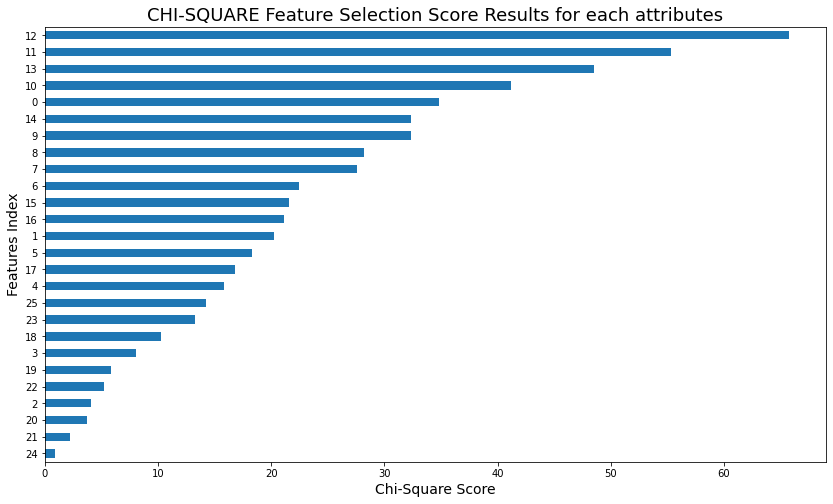

In [7]:
chi2_series = pd.Series(fs_chi_square.scores_).sort_values(ascending=True)
plt.figure(figsize=(14,8))
plt.title('CHI-SQUARE Feature Selection Score Results for each attributes', size=18)
chi2_series.plot(kind='barh')
plt.ylabel('Features Index', size=14)
plt.xlabel('Chi-Square Score', size=14)
plt.show()

In [8]:
# select for 4 top features
fs_chi_square = SelectKBest(score_func=chi2, k=number_of_selected_features)
fs_chi_square.fit(X_train, y_train)
X_train_fs_chi_square = fs_chi_square.transform(X_train)
X_test_fs_chi_square = fs_chi_square.transform(X_test)

### ANOVA F-Selection

In [9]:
fs_anova = SelectKBest(score_func=f_classif, k='all')
fs_anova.fit(X_train, y_train)
X_train_fs_anova = fs_anova.transform(X_train)
X_test_fs_anova = fs_anova.transform(X_test)

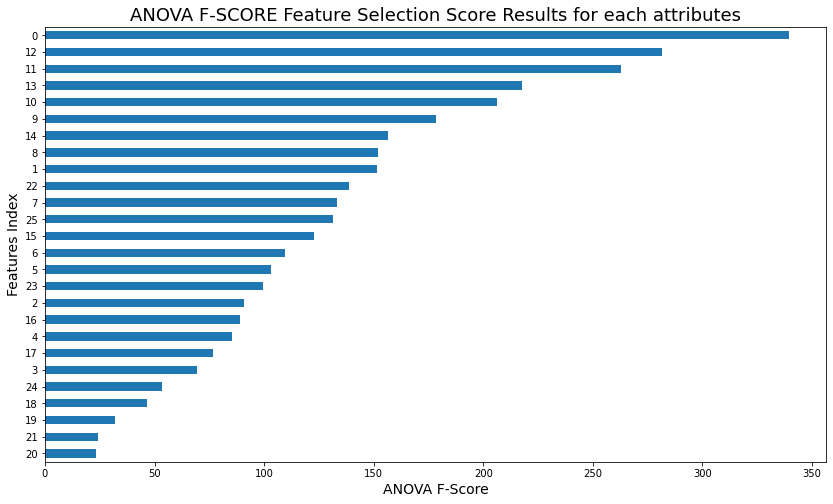

In [10]:
anova_series = pd.Series(fs_anova.scores_).sort_values(ascending=True)
plt.figure(figsize=(14,8))
plt.title('ANOVA F-SCORE Feature Selection Score Results for each attributes', size=18)
anova_series.plot(kind='barh')
plt.ylabel('Features Index', size=14)
plt.xlabel('ANOVA F-Score', size=14)
plt.show()

In [11]:
fs_anova = SelectKBest(score_func=f_classif, k=number_of_selected_features)
fs_anova.fit(X_train, y_train)
X_train_fs_anova = fs_anova.transform(X_train)
X_test_fs_anova = fs_anova.transform(X_test)

### Principal Component Analysis (PCA)

In [12]:
# Fit training data into PCA calculation
pca_model = PCA()
pca_model.fit(X_train)

pca_component_results = pd.DataFrame({
    'Komponen ke-': [i+1 for i in range(0,X_train.shape[1])],
    'Variance': pca_model.explained_variance_,
    'Proporsi Variance': pca_model.explained_variance_ratio_,
    'Kumulatif Proporsi Variance': pca_model.explained_variance_ratio_.cumsum()
})

In [13]:
pca_component_results

,Komponen ke-,Variance,Proporsi Variance,Kumulatif Proporsi Variance
0,1,3.233397e-01,8.349178e-01,0.834918
1,2,3.251115e-02,8.394931e-02,0.918867
2,3,1.351601e-02,3.490063e-02,0.953768
3,4,6.357455e-03,1.641603e-02,0.970184
4,5,3.219417e-03,8.313081e-03,0.978497
5,6,1.466405e-03,3.786507e-03,0.982283
6,7,1.301777e-03,3.361410e-03,0.985645
7,8,1.000267e-03,2.582860e-03,0.988228
8,9,8.001937e-04,2.066236e-03,0.990294
9,10,5.968860e-04,1.541261e-03,0.991835


In [14]:
best_pca_component = pca_component_results[
    pca_component_results['Kumulatif Proporsi Variance']>=threshold_cumsum
].index[0]+1
print('Best Principal Component using = ', best_pca_component)

Best Principal Component using =  4


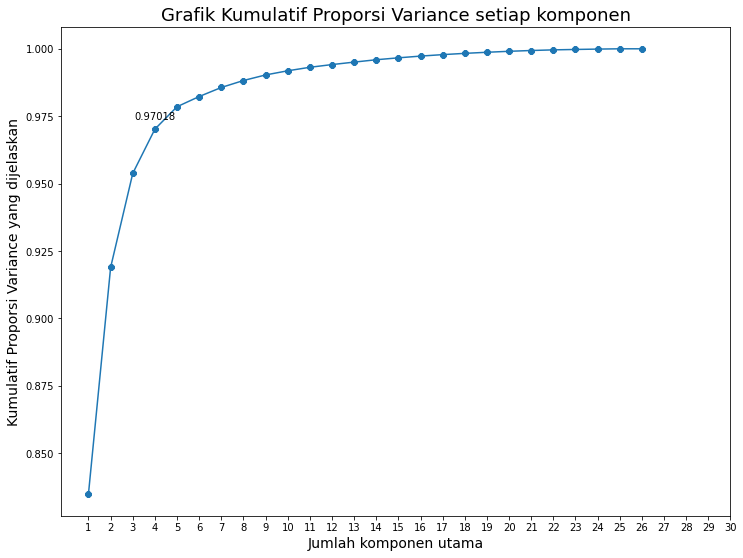

In [15]:
cumsum_component_explained = pca_model.explained_variance_ratio_.cumsum()
customs_labels = [i+1 for i in range(0,30)]
string_label = best_pca_component
xs = range(0,30)

plt.figure(figsize=(12,9))
pd.Series(cumsum_component_explained).plot(marker="8")
plt.xticks(ticks=xs, labels=customs_labels)
plt.title('Grafik Kumulatif Proporsi Variance setiap komponen', size=18)
plt.xlabel('Jumlah komponen utama', size=14)
plt.ylabel('Kumulatif Proporsi Variance yang dijelaskan',size=14)

label_index = customs_labels.index(best_pca_component)
xs_index = xs[label_index]
text = round(pca_component_results[
    pca_component_results['Kumulatif Proporsi Variance']>=threshold_cumsum
].iloc[0]['Kumulatif Proporsi Variance'],5)
plt.annotate(
    text, 
    (xs_index,text),
    textcoords="offset points",
    xytext=(0,10),
    ha='center'
)

plt.show()

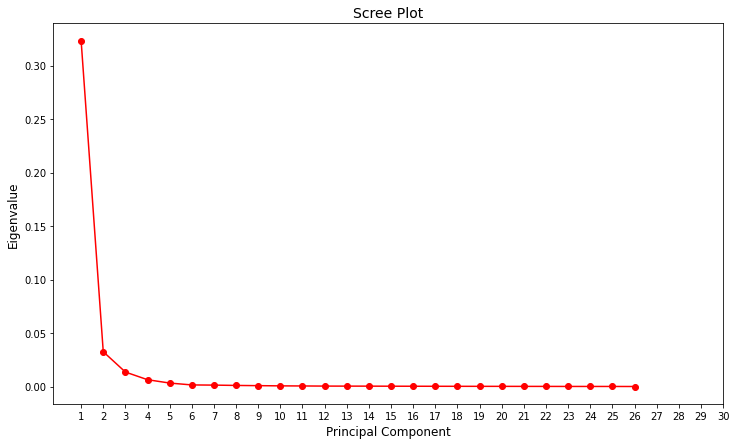

In [16]:
eigen_values = pca_model.explained_variance_
eigen_vectors = pca_model.components_
plt.figure(figsize=(12,7))
plt.plot(
    eigen_values,'r-o'
)
plt.title('Scree Plot', size=14)
plt.xticks(ticks=range(0,30), labels=[i+1 for i in range(0,30)])
plt.xlabel('Principal Component', size=12)
plt.ylabel('Eigenvalue',size=12) 
plt.show()

In [17]:
pca_scaler = PCA(n_components=best_pca_component)
pca_scaler.fit(X_train)
X_train_pca = pca_scaler.transform(X_train)
X_test_pca = pca_scaler.transform(X_test)

### Pearson Correlation
***
The correlation coefficient has values between -1 to 1
- A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
- A value closer to 1 implies stronger positive correlation
- A value closer to -1 implies stronger negative correlation

We will only select features which has correlation of **above 0.5** (taking absolute value) with the output variable.

Collinearity is a very common problem in machine learning projects. It is the correlation between the features of a dataset and it can reduce the performance of our models because it increases variance and the number of dimensions.

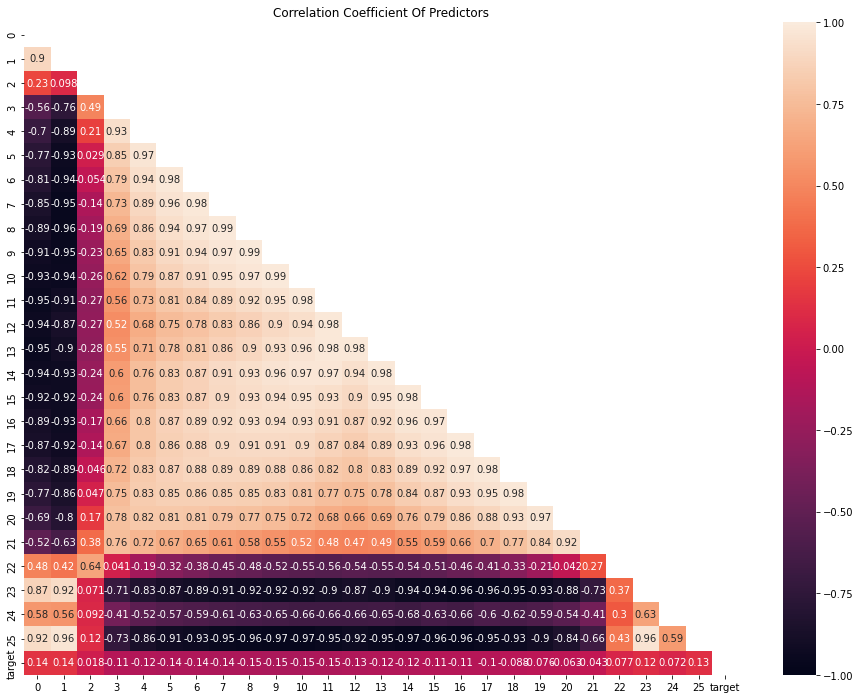

In [18]:
pearson_train_df = pd.DataFrame(X_train)
pearson_train_df['target'] = y_train

#Using Pearson Correlation
plt.figure(figsize=(16,12))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(pearson_train_df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(pearson_train_df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [19]:
# #Correlation with output variable
# cor_target = abs(cor["MEDV"])

# #Selecting highly correlated features
# relevant_features = cor_target[cor_target>0.5]
# relevant_features

## Ensemble for Chi-square

### Create Stacking ML Ensemble from 5-fold cross-validation

In [20]:
# create ensemble classifiers for Chi-square F-selection
ensemble_classifiers_chi_square = EnsembleStacking(X_train_fs_chi_square, y_train, X_test_fs_chi_square, y_test, kfold).train_ensemble()

In [21]:
ensemble_classifiers_chi_square

{'svm': {'model-1': {'train': SVC(),
   'training': 0.6184792588264753,
   'validation': 0.6178237650200267,
   'testing': 0.6182242990654205},
  'model-2': {'train': SVC(),
   'training': 0.616893414573074,
   'validation': 0.6174899866488651,
   'testing': 0.6172897196261682},
  'model-3': {'train': SVC(),
   'training': 0.6190953096311134,
   'validation': 0.6176961602671118,
   'testing': 0.6188473520249221},
  'model-4': {'train': SVC(),
   'training': 0.6193456851944583,
   'validation': 0.6180300500834724,
   'testing': 0.6194704049844236},
  'model-5': {'train': SVC(),
   'training': 0.6194291437155733,
   'validation': 0.6173622704507512,
   'testing': 0.6200934579439252}},
 'logreg': {'model-1': {'train': LogisticRegression(solver='newton-cg'),
   'training': 0.6216509473332776,
   'validation': 0.6204939919893191,
   'testing': 0.6214953271028038},
  'model-2': {'train': LogisticRegression(solver='newton-cg'),
   'training': 0.621150154411151,
   'validation': 0.623831775700

### Create new input Training from the stacking ensemble ML

In [22]:
new_input_training_features_chi_square = create_new_input_training_features(
    ensemble_classifiers_chi_square, 
    X_train_fs_chi_square,
    y_train
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


### Feed New Input features into ANN

In [23]:
# split X and y from new_input_features before feeding to ANN
new_X_train_chi_square = new_input_training_features_chi_square.drop(['ground_truth'],axis=1)
new_y_train_chi_square = new_input_training_features_chi_square['ground_truth']

# new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=45)

# feed new X and new y into ANN
ann_model_fs_chi_square = MLPClassifier(max_iter=max_iter, batch_size=batch_size, verbose=verbose, n_iter_no_change=n_iter_no_change)
ann_model_fs_chi_square.fit(new_X_train_chi_square, new_y_train_chi_square)

predicted_ann_train_chi_square = ann_model_fs_chi_square.predict(new_X_train_chi_square)

# print final results classification
print(accuracy_score(new_y_train_chi_square, predicted_ann_train_chi_square))

Iteration 1, loss = 0.63244129
Iteration 2, loss = 0.16465000
Iteration 3, loss = 0.05886946
Iteration 4, loss = 0.02814181
Iteration 5, loss = 0.01532873
Iteration 6, loss = 0.00917171
Iteration 7, loss = 0.00592939
Iteration 8, loss = 0.00400901
Iteration 9, loss = 0.00280261
Iteration 10, loss = 0.00199418
Iteration 11, loss = 0.00153143
Iteration 12, loss = 0.00116957
Iteration 13, loss = 0.00094032
Iteration 14, loss = 0.00077125
Iteration 15, loss = 0.00064902
Iteration 16, loss = 0.00056178
Iteration 17, loss = 0.00050070
Iteration 18, loss = 0.00045861
Iteration 19, loss = 0.00042698
Iteration 20, loss = 0.00040312
Iteration 21, loss = 0.00038640
Iteration 22, loss = 0.00037493
Iteration 23, loss = 0.00036596
Iteration 24, loss = 0.00035869
Iteration 25, loss = 0.00035232
Iteration 26, loss = 0.00034610
Iteration 27, loss = 0.00033952
Iteration 28, loss = 0.00033293
Iteration 29, loss = 0.00032606
Iteration 30, loss = 0.00031897
Iteration 31, loss = 0.00031196
Iteration 32, los

## Ensemble for ANOVA F-selection 

### Create Stacking ML Ensemble from 5-fold cross-validation

In [24]:
# create ensemble classifiers for ANOVA F-selection
ensemble_classifiers_anova = EnsembleStacking(X_train_fs_anova, y_train, X_test_fs_anova, y_test, kfold).train_ensemble()

In [25]:
ensemble_classifiers_anova

{'svm': {'model-1': {'train': SVC(),
   'training': 0.6149737083715884,
   'validation': 0.6148197596795728,
   'testing': 0.6149532710280374},
  'model-2': {'train': SVC(),
   'training': 0.6154745012937151,
   'validation': 0.6151535380507344,
   'testing': 0.6152647975077882},
  'model-3': {'train': SVC(),
   'training': 0.6154231347020531,
   'validation': 0.6146911519198665,
   'testing': 0.6151090342679127},
  'model-4': {'train': SVC(),
   'training': 0.6152562176598231,
   'validation': 0.6150250417362271,
   'testing': 0.6154205607476636},
  'model-5': {'train': SVC(),
   'training': 0.6153396761809381,
   'validation': 0.6153589315525877,
   'testing': 0.6152647975077882}},
 'logreg': {'model-1': {'train': LogisticRegression(solver='newton-cg'),
   'training': 0.6198147066188131,
   'validation': 0.6224966622162884,
   'testing': 0.6185358255451714},
  'model-2': {'train': LogisticRegression(solver='newton-cg'),
   'training': 0.619731241131792,
   'validation': 0.62349799732

### Create new input training from the stacking ensemble ML

In [26]:
new_input_training_features_anova = create_new_input_training_features(
    ensemble_classifiers_anova, 
    X_train_fs_anova,
    y_train
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


### Feed new input features into ANN

In [27]:
# split X and y from new_input_features before feeding to ANN
new_X_train_anova = new_input_training_features_anova.drop(['ground_truth'],axis=1)
new_y_train_anova = new_input_training_features_anova['ground_truth']

# new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=45)

# feed new X and new y into ANN
ann_model_fs_anova = MLPClassifier(max_iter=max_iter, batch_size=batch_size, verbose=verbose, n_iter_no_change=n_iter_no_change)
ann_model_fs_anova.fit(new_X_train_anova, new_y_train_anova)

predicted_ann_train_anova = ann_model_fs_anova.predict(new_X_train_anova)

# print final results classification
print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Data = ", accuracy_score(new_y_train_anova, predicted_ann_train_anova))

Iteration 1, loss = 0.73119594
Iteration 2, loss = 0.19127251
Iteration 3, loss = 0.05438900
Iteration 4, loss = 0.02263807
Iteration 5, loss = 0.01181051
Iteration 6, loss = 0.00674804
Iteration 7, loss = 0.00446956
Iteration 8, loss = 0.00328751
Iteration 9, loss = 0.00251726
Iteration 10, loss = 0.00205915
Iteration 11, loss = 0.00170772
Iteration 12, loss = 0.00140628
Iteration 13, loss = 0.00118757
Iteration 14, loss = 0.00094911
Iteration 15, loss = 0.00085088
Iteration 16, loss = 0.00072268
Iteration 17, loss = 0.00060430
Iteration 18, loss = 0.00052875
Iteration 19, loss = 0.00047834
Iteration 20, loss = 0.00044300
Iteration 21, loss = 0.00041622
Iteration 22, loss = 0.00039714
Iteration 23, loss = 0.00038107
Iteration 24, loss = 0.00037202
Iteration 25, loss = 0.00036228
Iteration 26, loss = 0.00035567
Iteration 27, loss = 0.00034850
Iteration 28, loss = 0.00034355
Iteration 29, loss = 0.00033769
Iteration 30, loss = 0.00033197
Iteration 31, loss = 0.00032704
Iteration 32, los

## Ensemble for PCA Dimensionality Reduction

### Create Stacking ML Ensemble from 5-fold cross-validation

In [28]:
min_max_pca = MinMaxScaler()
min_max_pca.fit(X_train_pca)
X_train_pca = min_max_pca.transform(X_train_pca)
X_test_pca = min_max_pca.transform(X_test_pca)

In [29]:
# create ensemble classifiers for PCA
ensemble_classifiers_pca = EnsembleStacking(X_train_pca, y_train, X_test_pca, y_test, kfold).train_ensemble()

In [30]:
ensemble_classifiers_pca

{'svm': {'model-1': {'train': SVC(),
   'training': 0.6278273933728403,
   'validation': 0.6224966622162884,
   'testing': 0.6249221183800623},
  'model-2': {'train': SVC(),
   'training': 0.626825807528587,
   'validation': 0.6258344459279038,
   'testing': 0.625233644859813},
  'model-3': {'train': SVC(),
   'training': 0.627274244700384,
   'validation': 0.6233722871452421,
   'testing': 0.625233644859813},
  'model-4': {'train': SVC(),
   'training': 0.6281088299115339,
   'validation': 0.6230383973288814,
   'testing': 0.6249221183800623},
  'model-5': {'train': SVC(),
   'training': 0.628275746953764,
   'validation': 0.6247078464106844,
   'testing': 0.6264797507788162}},
 'logreg': {'model-1': {'train': LogisticRegression(solver='newton-cg'),
   'training': 0.619063517235623,
   'validation': 0.6138184245660881,
   'testing': 0.6169781931464174},
  'model-2': {'train': LogisticRegression(solver='newton-cg'),
   'training': 0.6171438110341374,
   'validation': 0.619826435246996,

### Create new input training from the stacking ensemble ML

In [31]:
new_input_training_features_pca = create_new_input_training_features(
    ensemble_classifiers_pca, 
    X_train_pca,
    y_train
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


### Feed new input features into ANN

In [32]:
# split X and y from new_input_features before feeding to ANN
new_X_train_pca = new_input_training_features_pca.drop(['ground_truth'],axis=1)
new_y_train_pca = new_input_training_features_pca['ground_truth']

# new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=45)

# feed new X and new y into ANN
ann_model_pca = MLPClassifier(max_iter=max_iter, batch_size=batch_size, verbose=verbose, n_iter_no_change=n_iter_no_change)
ann_model_pca.fit(new_X_train_pca, new_y_train_pca)

predicted_ann_train_pca = ann_model_pca.predict(new_X_train_pca)

# print final results classification
print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Data = ", accuracy_score(new_y_train_pca, predicted_ann_train_pca))

Iteration 1, loss = 0.73607525
Iteration 2, loss = 0.22176782
Iteration 3, loss = 0.08072616
Iteration 4, loss = 0.03562850
Iteration 5, loss = 0.01851797
Iteration 6, loss = 0.01066676
Iteration 7, loss = 0.00664504
Iteration 8, loss = 0.00434694
Iteration 9, loss = 0.00297924
Iteration 10, loss = 0.00212503
Iteration 11, loss = 0.00156345
Iteration 12, loss = 0.00119465
Iteration 13, loss = 0.00094226
Iteration 14, loss = 0.00076536
Iteration 15, loss = 0.00064259
Iteration 16, loss = 0.00055562
Iteration 17, loss = 0.00048934
Iteration 18, loss = 0.00043580
Iteration 19, loss = 0.00040211
Iteration 20, loss = 0.00038136
Iteration 21, loss = 0.00036781
Iteration 22, loss = 0.00035867
Iteration 23, loss = 0.00035180
Iteration 24, loss = 0.00034593
Iteration 25, loss = 0.00034029
Iteration 26, loss = 0.00033474
Iteration 27, loss = 0.00032904
Iteration 28, loss = 0.00032308
Iteration 29, loss = 0.00031699
Iteration 30, loss = 0.00031072
Iteration 31, loss = 0.00030469
Iteration 32, los

# Save Stacking Model Pretrained (MLs + ANN)

In [33]:
# save trained ensemble stacking classifiers
model_ensemble_experiment_2 = {
    'chi-square':{
        'stacking_ensembles': ensemble_classifiers_chi_square,
        'ann': ann_model_fs_chi_square,
        'data': {
            'training': {
                'X': X_train_fs_chi_square,
                'y': y_train
            },
            'testing': {
                'X': X_test_fs_chi_square,
                'y': y_test
            }
        }
    },
    'anova':{
        'stacking_ensembles': ensemble_classifiers_anova,
        'ann': ann_model_fs_anova,
        'data': {
            'training': {
                'X': X_train_fs_anova,
                'y': y_train
            },
            'testing': {
                'X': X_test_fs_anova,
                'y': y_test
            }
        }
    },
    'pca':{
        'stacking_ensembles': ensemble_classifiers_pca,
        'ann': ann_model_pca,
        'data': {
            'training': {
                'X': X_train_pca,
                'y': y_train
            },
            'testing': {
                'X': X_test_pca,
                'y': y_test
            }
        }
    }
   
}
pickle.dump(model_ensemble_experiment_2, open("model_ensemble_experiment_results/model_ensemble_eksperimen_2.pkl", 'wb'))